# Principal Component Analysis: an application to factor models

#### Author: Gustavo Soares

## Introduction

The SDF framework gave us the so called **beta representation**:

$$
E_{t}[R^{e}_{i,t+1}] = \alpha_{i,t} + \beta_{i,t}´\lambda_{t}
$$

If markets are efficient under that particular asset pricing model, then we should have $\alpha_{i,t} = 0$. We therefore can use data to test if $\alpha_{i,t} = 0$ or not. If we find that $\alpha_{i,t} \neq 0$, then we have found an **anomaly**. However, we also discussed how we need to be careful with the interpretation of the term **anomaly** because of the **join-hypothesis problem**. The **anomaly**, $\alpha_{i,t} \neq 0$, is only evidence that the market is inefficient if our model is correct. However, under an expanded, enhanced or enriched market equilibrium model that anomaly may not be an anomaly at all and we may go back to $\alpha_{i,t} = 0$ if we use a different model.

Broadly speaking, the rationale behind factor models is that the financial performance of assets depends on a relative small number of factors. These factors may be latent and unobservable and ultimately unkown to us. However, they may be related to intrinsic asset characteristics like the accounting ratios for stocks, carry for currencies and rates or the size of non-commercial speculative positions in commodities.

Here we will use an old unsupervised learning technique, Principal Component Analysis (PCA), to try to make the point that financial performance of assets depends on a relative small number of factors. We will pull data for 93 different markets and try to see how many latent factors drive them. These are futures markets where we constructed the "tracker" data by rolling futures over time and calculating the pnl in USD. So, the data is really ready to go. Let's import what we are going to need and grab the data:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
futures = pd.read_csv('futures.csv', index_col=0)
futures.index = pd.to_datetime(futures.index)

Most techniques in statistics require the data to be stationary. Hopefully, you know what that means. Excess return indices are typically not stationary, so we will convert the data to log-returns to make it so:

In [2]:
returns_df = np.log(futures.dropna().resample('M').last()).diff(1).astype(float)

### Principal Components Analysis

PCA is a statistical method that explains variance-covariance structure by employing a linear combination of the original $p$ random variables $X_{1}, . . . ,X_{p}$. Let the $px1$ random vector $X = (X_{1}, . . . ,X_{p})'$ have the $pxp$ covariance matrix $\Omega$ with eigenvalues $\lambda_{1}\geq . . . \geq \lambda_{i} . . . \geq \lambda_{p}$ and associated eigenvectors $e_{1}, . . . ,e_{p}$.

The $i$-th principal component is the vector $P_{i} = e_{i}'X$.

By construction:

* $e_{i}'e_{i} = 1$ for all $i = 1,...,p$;
* $e_{i}'e_{j} = 0$ for all $i \neq j$;;
* $Var(P_{i}) = e_{i}'\Omega e_{i}$ for all $i = 1,...,p$;
* $Cov(P_{i},P_{j}) = e_{i}'\Omega e_{j}$ for all $i \neq j$;
* $\sum_{i=1}^{p} Var(X_{i}) = \sum_{i=1}^{p} \lambda_{i}$

**Note**: Note that if $P_{i}$ is principal component, then $-P_{i}$ could also be a principal component. That is, principal components are identified up to a sign. Different packages or even the same packages can spit out $P_{i}$ or $-P_{i}$ as their output. You never know. So, don't get bogged down on the direction of $P_{i}$. Let's calculate the principal components:

In [3]:
cov = returns_df.cov()
eig_vals, eig_vecs = np.linalg.eig(cov)

idx = eig_vals.argsort()[::-1]
eig_vals = eig_vals[idx]
eig_vecs = eig_vecs[:, idx]

pca_loadings = pd.DataFrame(index=cov.index,
                            columns=['PC_' + str(i)
                                     for i in range(1, cov.shape[1] + 1)],
                            data=eig_vecs).astype(float)
lambdas = eig_vals.astype(float)
pc_ts = (returns_df[pca_loadings.index]@pca_loadings).astype(float)

C:\Users\gsoares\AppData\Local\Continuum\anaconda3\envs\bwgi\lib\site-packages\pandas\core\dtypes\cast.py:897: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
<ipython-input-3-d8a36af1a21e>:12: ComplexWarning: Casting complex values to real discards the imaginary part
  lambdas = eig_vals.astype(float)


The charts below show $e_{i}$ for $i=1,\dots,3$. This may help us give some economic interpretation to the PCs. For exaemplo, typically, the PC1 is associated with "risk on/off" shocks to the markets.

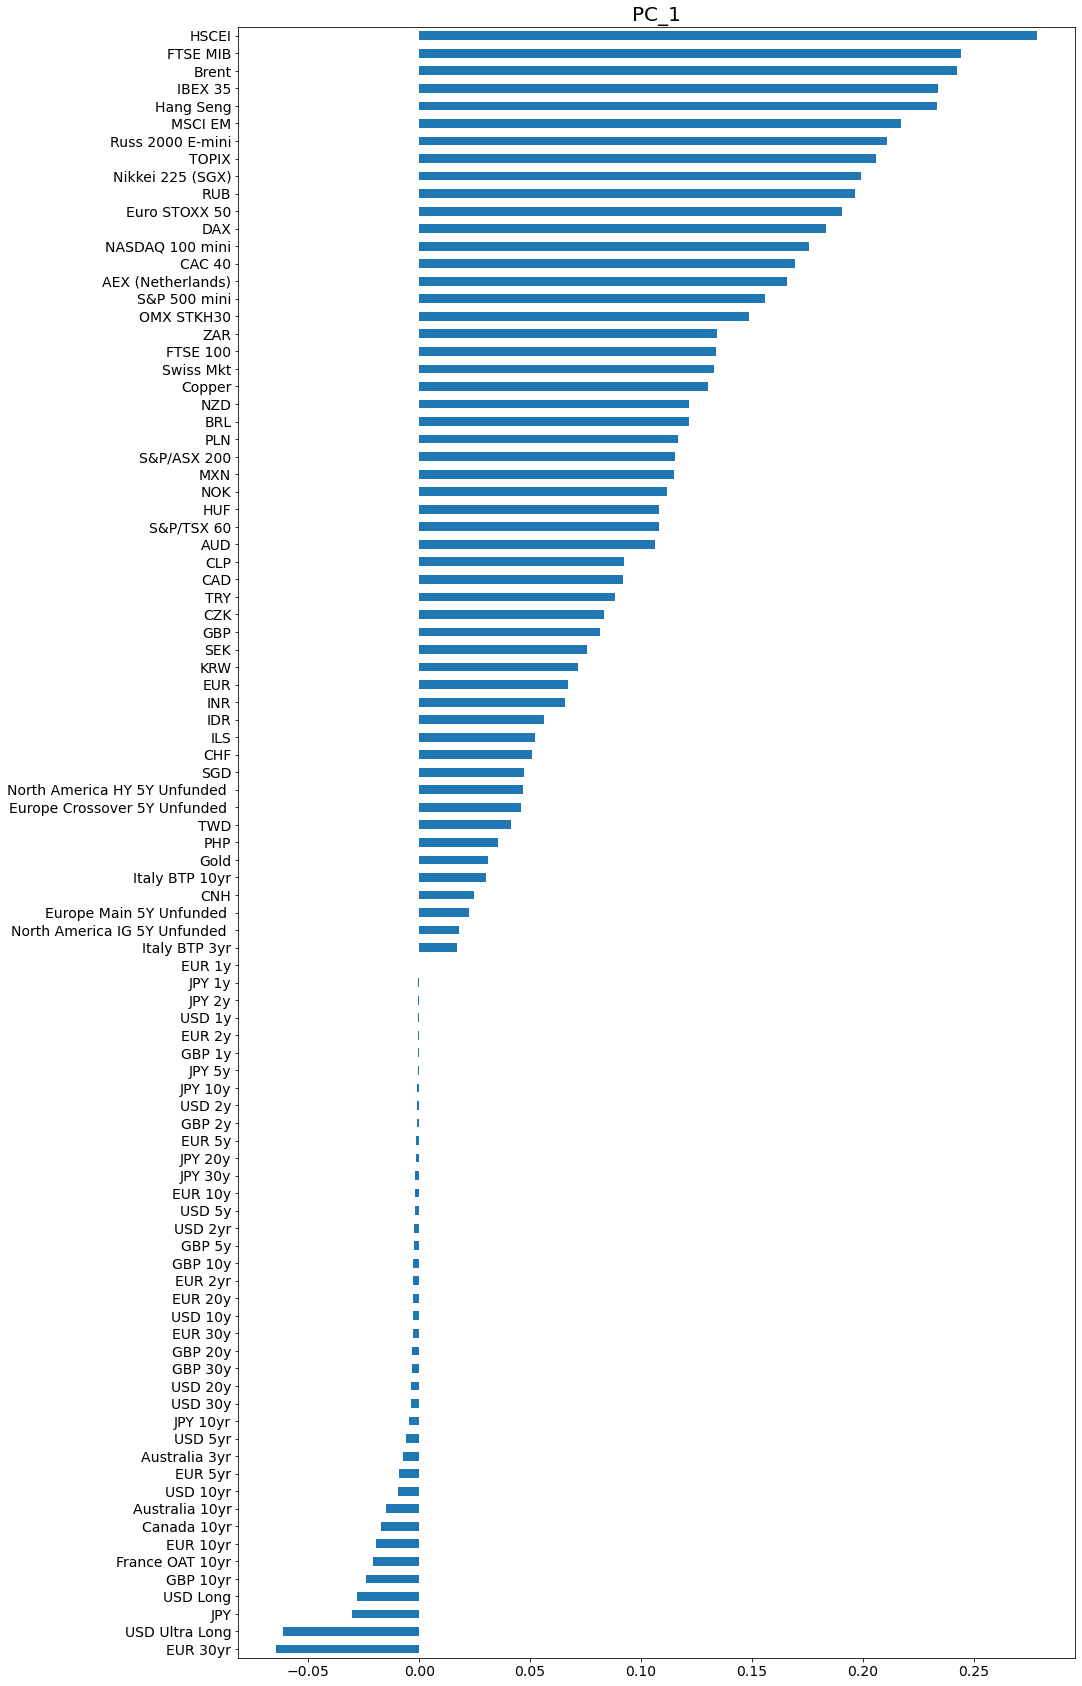

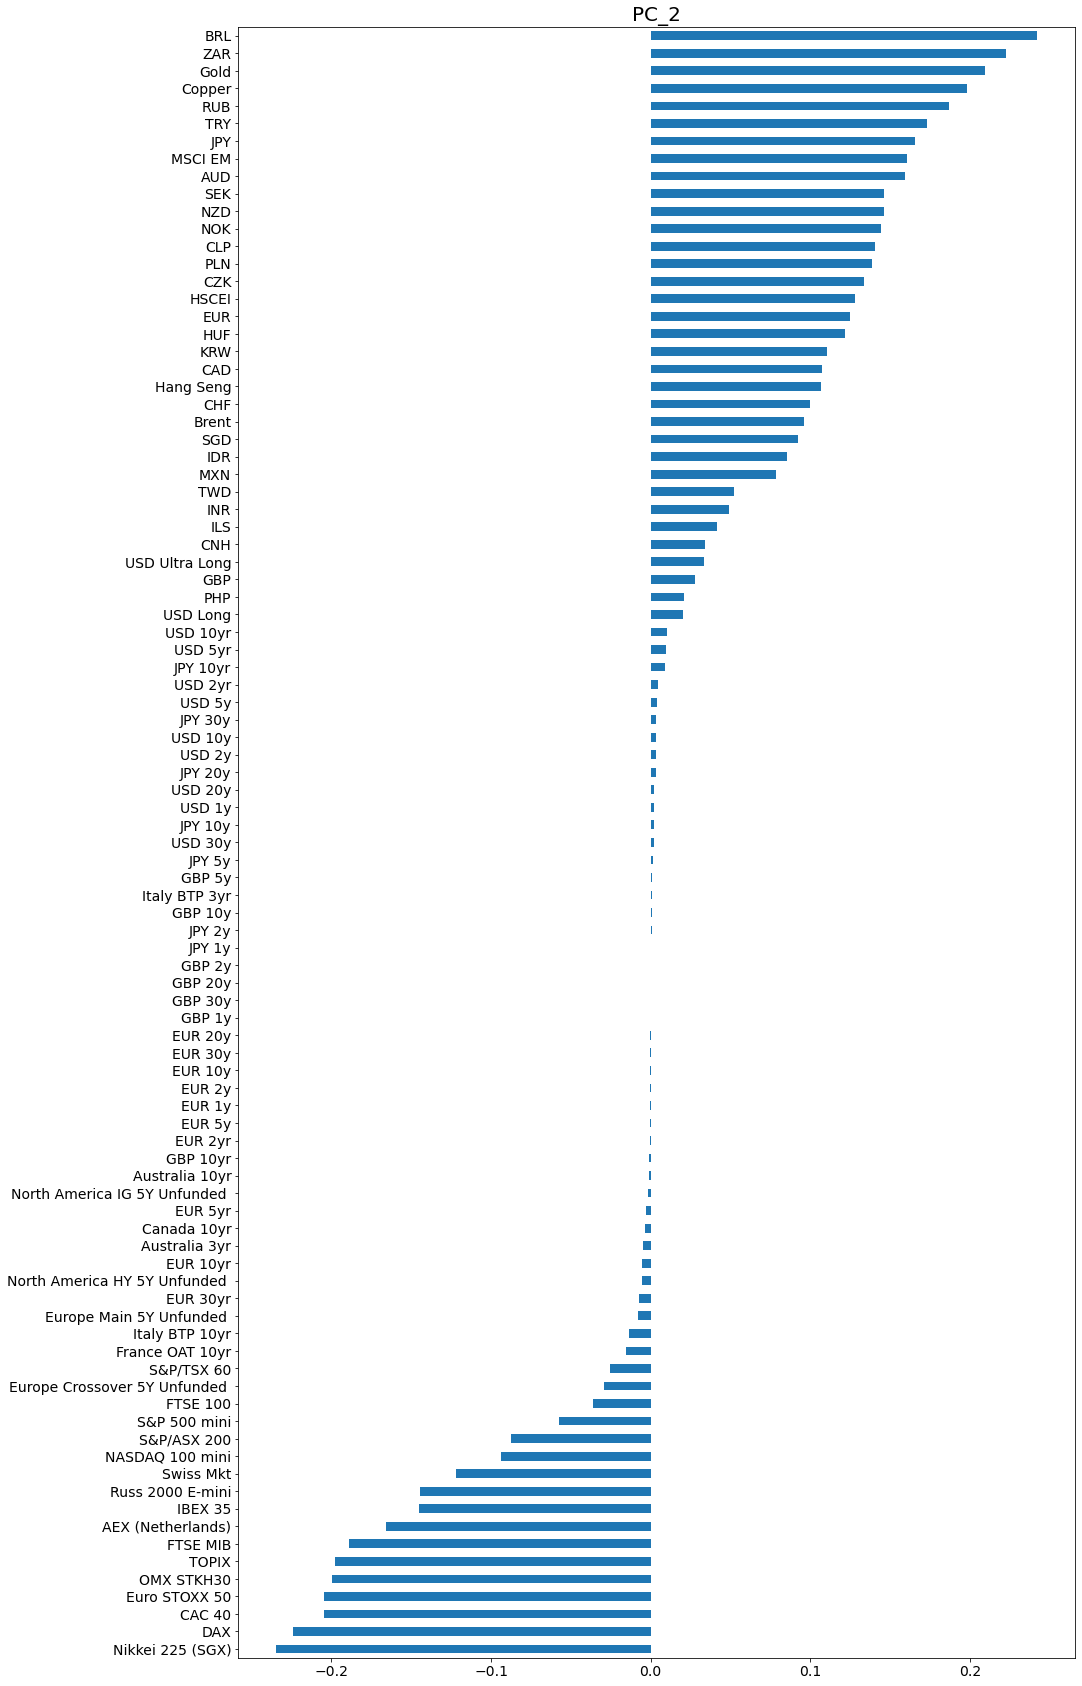

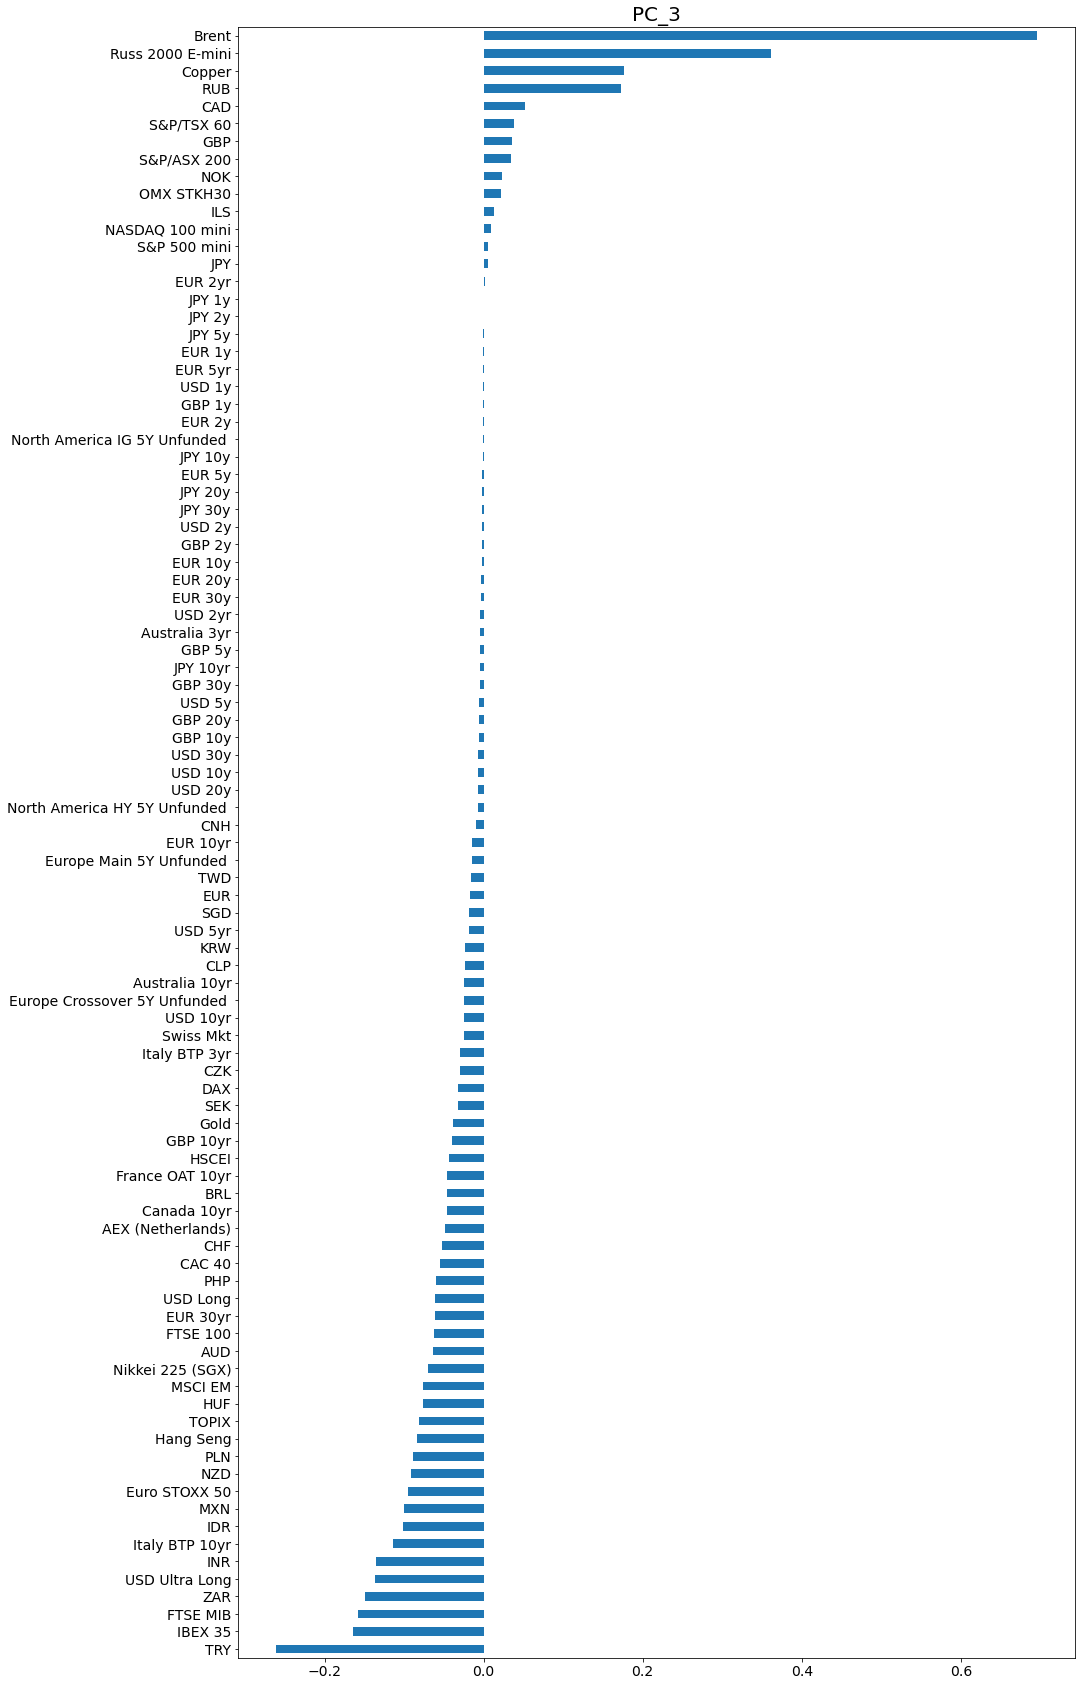

In [4]:
for i in range(3):
    pca_loadings.iloc[:,i].sort_values().plot(kind='barh', figsize=(15,30), fontsize=14)
    plt.title(pca_loadings.columns[i], fontsize=20)
    plt.show()

The charts below show the actual time series of the principal component vector $P_{i, t} = e_{i}'X_{t}$ for $i=1,\dots,3$ and every $t$ in the sample. To make it easier to see how the principal components move over time, we will acumulate the changes over time:

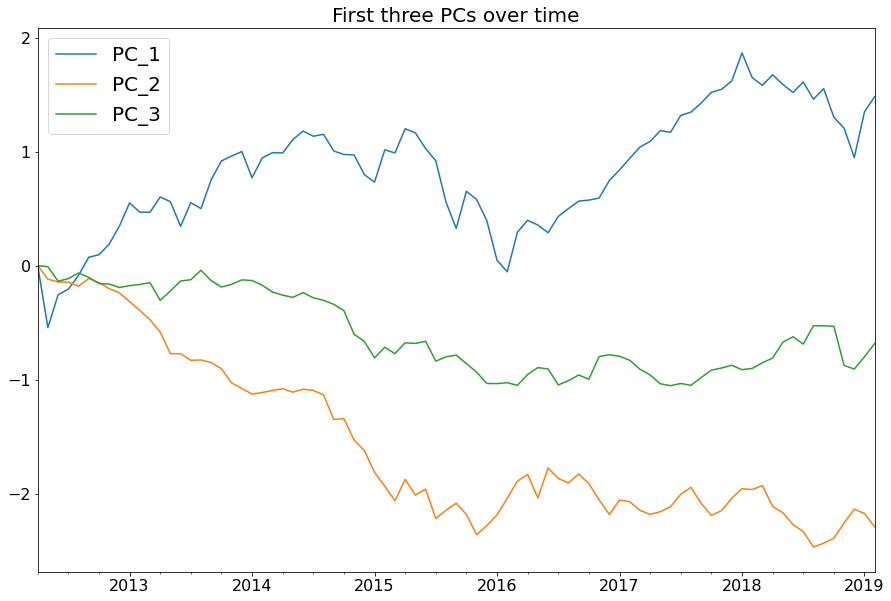

In [5]:
pc_ts.iloc[:,:3].fillna(0).cumsum().plot(figsize=(15,10), fontsize=16)
plt.title('First three PCs over time', fontsize=20)
plt.legend(fontsize=20)
plt.show()

What do you think? What do these time series look like? Remember that the PCs are uncorrelated by construction:

In [6]:
(pc_ts.iloc[:,:3].corr()*100).astype(int)

,PC_1,PC_2,PC_3
PC_1,100,0,0
PC_2,0,100,0
PC_3,0,0,100


Because we know that $\sum_{i=1}^{p} Var(X_{i}) = \sum_{i=1}^{p} \lambda_{i}$. We can think of the magnitude of lambda as how much of the variability of the data can be explained by each principal component. For instance, the proportion of the data variability (as measured by $\Omega$) explained by the i-th PC is given by $\lambda_{k} / \sum_{k=1}^{p} \lambda_{k}$.

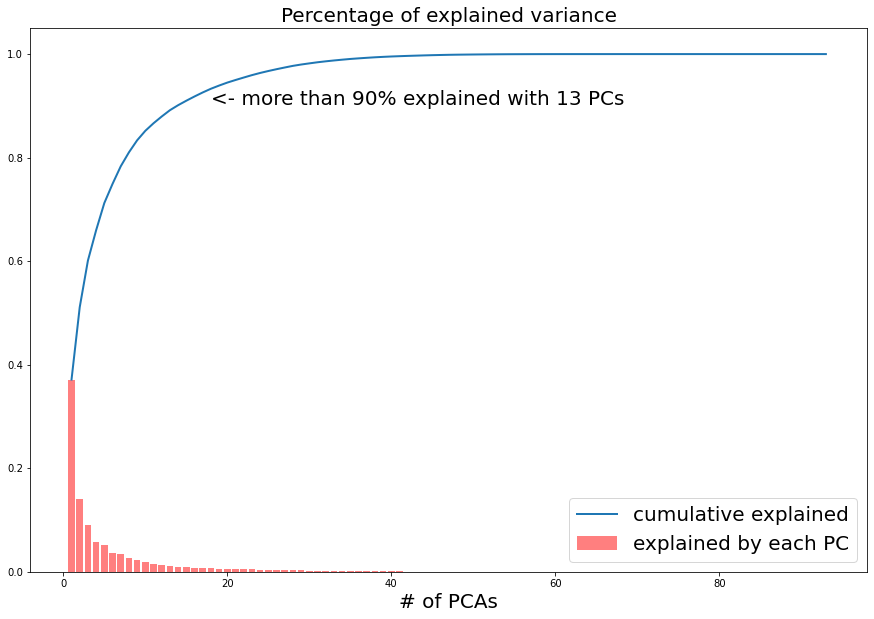

In [25]:
explained_variance = lambdas/lambdas.sum()
cumm_explained_variance = [explained_variance[0]]
for i in range(1,len(explained_variance)):
    cumm_explained_variance.append(cumm_explained_variance[i-1] + explained_variance[i])
plt.figure(figsize=(15, 10))
plt.plot(range(1,len(explained_variance)+1),cumm_explained_variance/np.sum(explained_variance), linewidth=2)
plt.bar(range(1,len(explained_variance)+1), explained_variance/np.sum(explained_variance), align='center', alpha=0.5, color='r')
plt.xlabel('# of PCAs', fontsize=20)
plt.title('Percentage of explained variance', fontsize=20)
plt.legend(['cumulative explained', 'explained by each PC'], fontsize=20)
k, z = [(i, cumm_explained_variance[i]) for i in range(len(cumm_explained_variance)) if cumm_explained_variance[i]>0.9][0]
plt.text(k+5, z, f'<- more than 90% explained with {k} PCs', fontsize=20)
plt.show()